In [1]:
!git clone https://github.com/Zymrael/torchSODE.git

Cloning into 'torchSODE'...
remote: Enumerating objects: 678, done.
remote: Total 678 (delta 0), reused 0 (delta 0), pack-reused 678
Receiving objects: 100% (678/678), 1.01 MiB | 2.25 MiB/s, done.
Resolving deltas: 100% (442/442), done.


In [2]:
!cd ./torchSODE/src/ && python3 setup.py install

running install
running bdist_egg
running egg_info
creating torchSODE.egg-info
writing torchSODE.egg-info/PKG-INFO
writing dependency_links to torchSODE.egg-info/dependency_links.txt
writing top-level names to torchSODE.egg-info/top_level.txt
writing manifest file 'torchSODE.egg-info/SOURCES.txt'
writing manifest file 'torchSODE.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_ext
building 'torchSODE' extension
creating build
creating build/temp.linux-x86_64-3.6
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/torch/include -I/usr/local/lib/python3.6/dist-packages/torch/include/torch/csrc/api/include -I/usr/local/lib/python3.6/dist-packages/torch/include/TH -I/usr/local/lib/python3.6/dist-packages/torch/include/THC -I/usr/local/cuda/include -I/usr/include/python3.6m -c solver

In [3]:
!git clone https://github.com/rtqichen/torchdiffeq
!cd torchdiffeq && pip install -e .

Cloning into 'torchdiffeq'...
remote: Enumerating objects: 138, done.
remote: Total 138 (delta 0), reused 0 (delta 0), pack-reused 138
Receiving objects: 100% (138/138), 688.35 KiB | 1.83 MiB/s, done.
Resolving deltas: 100% (55/55), done.
Obtaining file:///content/torchdiffeq
  Running setup.py develop for torchdiffeq


In [4]:
!pip install ipyexperiments

In [0]:
import ipyexperiments
import timeit
import time
from functools import partial

In [0]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.model_selection import train_test_split
import sklearn.datasets as datasets
import torchSODE
import torchdiffeq

In [0]:
torch.cuda.manual_seed_all(2)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Creating dataset

In [85]:
data = 'blobs'

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.001
･ CPU:          0          0      4,357 MB |
･ GPU:          0          0      4,279 MB |


In [86]:
def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.006
･ CPU:          0          0      4,357 MB |
･ GPU:          0          0      4,279 MB |


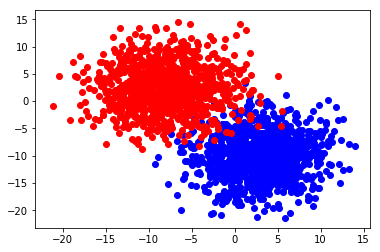

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.340
･ CPU:          0          0      4,357 MB |
･ GPU:          0          0      1,217 MB |


In [95]:
if data == 'blobs':
    X,yn = datasets.make_blobs(n_samples=2048, centers = 2,n_features=2, cluster_std=4)
    plt.scatter(X[yn==1,0],X[yn==1,1],color='blue')
    plt.scatter(X[yn==0,0],X[yn==0,1],color='red')
if data == 'moons':
    X, yn = datasets.make_moons(n_samples=10)
    plt.scatter(X[yn==1,0],X[yn==1,1],color='blue')
    plt.scatter(X[yn==0,0],X[yn==0,1],color='red')
if data == 'mclass':
    X, yn = datasets.make_classification(n_samples=500,n_informative=4,n_clusters_per_class=3,n_classes=3)
    plt.scatter(X[yn==1,0],X[yn==1,1],color='blue')
    plt.scatter(X[yn==0,0],X[yn==0,1],color='red')
    plt.scatter(X[yn==2,0],X[yn==2,1],color='green')
if data == 'spirals':
    X, yn = twospirals(512)
    plt.title('training set')
    plt.plot(X[yn==0,0], X[yn==0,1], '.', label='class 1')
    plt.plot(X[yn==1,0], X[yn==1,1], '.', label='class 2')
    plt.legend()

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, yn, test_size=0.5)

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.005
･ CPU:          0          0      4,357 MB |
･ GPU:          0          0      1,217 MB |


In [97]:
# choose batch size here
bs = 128

X_train = torch.Tensor(X_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
X_test = torch.Tensor(X_test).to(device)
y_test = torch.LongTensor(y_test).to(device)

train = data_utils.TensorDataset(X_train,y_train)
trainloader = data_utils.DataLoader(train, batch_size=bs, shuffle=True)

test = data_utils.TensorDataset(X_test,y_test)
testloader = data_utils.DataLoader(test, batch_size=bs, shuffle=True)

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.012
･ CPU:          0          0      4,357 MB |
･ GPU:          0          0      1,217 MB |


# Neural Network definition

In [98]:
class MLP(nn.Module):
    def __init__(self, dense_layers, softmax = True):
        '''
        Simple dense MLP class used as predictor
        
        :smax_l: leave True for softmax applied to ouput
        '''
        super().__init__()
        self.dense_layers = nn.ModuleList([nn.Linear(dense_layers[i], dense_layers[i + 1]) \
                                           for i in range(len(dense_layers) - 1)])
        self.softmax = softmax
        
    def getLength(self):
        return len(self.dense_layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.dense_layers:
            l_x = l(x)
            x = F.relu(l_x)
        if not self.softmax: return l_x
        else: return F.log_softmax(l_x, dim=-1)

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.019
･ CPU:          0          0      4,357 MB |
･ GPU:          0          0      1,217 MB |


# Training

In [99]:
exp1 = ipyexperiments.IPyExperimentsPytorch()


*** Experiment started with the Pytorch backend
Device: ID 0, Tesla T4 (15079 RAM)


*** Current state:
RAM:    Used    Free   Total       Util
CPU:   4,357  10,250  13,022 MB  33.46% 
GPU:   1,217  13,861  15,079 MB   8.08% 


･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.231
･ CPU:          0          0      4,357 MB |
･ GPU:          0          0      1,217 MB |

IPyExperimentsPytorch: Finishing

*** Experiment finished in 00:00:26 (elapsed wallclock time)

*** Experiment memory:
RAM: Consumed       Reclaimed
CPU:        0        0 MB (100.00%)
GPU:   -3,062        0 MB ( -0.00%)

*** Current state:
RAM:    Used    Free   Total       Util
CPU:   4,357  10,250  13,022 MB  33.46% 
GPU:   1,217  13,861  15,079 MB   8.08% 


･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.147
･ CPU:          0          0      4,357 MB |
･ GPU:          0          0      1,217 MB |


In [100]:
m = MLP([2, 10000, 10000, 1000, 1000, 2]).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#111 044 002 parameters
count_parameters(m)

111044002

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:01.127
･ CPU:          0          0      4,357 MB |
･ GPU:          0        422      1,217 MB |


In [101]:
# util to generate F matrix
def generateFS(size, UL, UR, LL, LR):
  n = size//2
  ul = UL*torch.eye(n)
  ur = UR*torch.eye(n) 
  ll = LL*torch.eye(n)
  lr = LR*torch.eye(n)
  top = torch.cat((ul, ur),1)
  bottom = torch.cat((ll, lr),1)
  return torch.cat((top, bottom), 0)

Fm = torch.eye(1).to(device)

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.012
･ CPU:          0          0      4,357 MB |
･ GPU:          0          0      1,217 MB |


In [102]:
#torchSODE SGD-like

m1 = MLP([2, 10000, 10000, 1000, 1000, 2]).to(device)
criterion = F.nll_loss
optimizer = torch.optim.SGD(m1.parameters(), lr=0.01, momentum=0.9)
epochs = 100
dt = 0.01 
ode_steps = 1
# timer for updating loop only
end_updating_timer1 = 0

training_timer1 = time.process_time()
for e in range(epochs):
    dataiter = iter(trainloader)

    for i, d in enumerate(dataiter):
        x, y = next(dataiter)
        x, y = x.cuda(), y.cuda()
        for j in range(ode_steps):
            loss = criterion(m1(x), y)
            loss.backward()
            updating_timer1 = time.process_time()
            with torch.no_grad():
                for p in m1.parameters():
                    torchSODE.solve(-Fm, p.view(-1), p.grad.view(-1), dt, 1, 'Euler')
            end_updating_timer1 += time.process_time() - updating_timer1
        m1.zero_grad()

end_training1 = time.process_time() - training_timer1
print(f"Entire training process took {round(end_training1, 4)} (s)")
print(f"Updating the parameters took {round(end_updating_timer1, 4)} (s)")

Entire training process took 16.1914 (s)
Updating the parameters took 13.8606 (s)
･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:16.741
･ CPU:          0          0      4,357 MB |
･ GPU:        864        424      2,081 MB |


In [139]:
#torchSODE with less params (for torchdiffeq)

m1_small = MLP([2, 1000, 1000, 1000, 1000, 2]).to(device)
criterion = F.nll_loss
optimizer = torch.optim.SGD(m1.parameters(), lr=0.01, momentum=0.9)
epochs = 100
dt = 0.01 
ode_steps = 1
# timer for updating loop only
end_updating_timer1 = 0

training_timer1 = time.process_time()
for e in range(epochs):
    dataiter = iter(trainloader)

    for i, d in enumerate(dataiter):
        x, y = next(dataiter)
        x, y = x.cuda(), y.cuda()
        for j in range(ode_steps):
            loss = criterion(m1_small(x), y)
            loss.backward()
            updating_timer1 = time.process_time()
            with torch.no_grad():
                for p in m1_small.parameters():
                    torchSODE.solve(-Fm, p.view(-1), p.grad.view(-1), dt, 1, 'Euler')
            end_updating_timer1 += time.process_time() - updating_timer1
        m1_small.zero_grad()

end_training1 = time.process_time() - training_timer1
print(f"Entire training process took {round(end_training1, 4)} (s)")
print(f"Updating the parameters took {round(end_updating_timer1, 4)} (s)")

Entire training process took 3.0164 (s)
Updating the parameters took 0.8056 (s)
･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:02.641
･ CPU:          0          0      4,361 MB |
･ GPU:          0         24      2,105 MB |


In [73]:
#torchSODE SGD-momentum like

m1_sk = MLP([2, 10000, 10000, 1000, 1000, 2]).to(device)
pdot = torch.zeros(count_parameters(m1)).to(device)
criterion = F.nll_loss
optimizer = torch.optim.SGD(m1.parameters(), lr=0.01, momentum=0.9)
epochs = 50
dt = 0.01 
Fm = generateFS(2, 0, 1, -1, -2).to(device)
ode_steps = 1
# timer for updating loop only
end_updating_timer1 = 0

training_timer1 = time.process_time()
for e in range(epochs):
    dataiter = iter(trainloader)

    for i, d in enumerate(dataiter):
        x, y = next(dataiter)
        x, y = x.cuda(), y.cuda()
        for j in range(ode_steps):
            loss = criterion(m1_sk(x), y)
            loss.backward()
            updating_timer1 = time.process_time()
            with torch.no_grad():
                k = 0
                for p in m1_sk.parameters():
                    n = torch.numel(p)
                    torchSODE.solve(Fm, torch.cat((p.view(-1), pdot[k:k+n]), 0), 
                                    torch.cat((p.grad.view(-1), 2 * pdot[k:k+n]), 0),
                                    dt, 1, 'Euler')
                    k += n
            end_updating_timer1 += time.process_time() - updating_timer1
        m1_sk.zero_grad()

end_training1 = time.process_time() - training_timer1
print(f"Entire training process took {round(end_training1, 4)} (s)")
print(f"Updating the parameters took {round(end_updating_timer1, 4)} (s)")

Entire training process took 12.6402 (s)
Updating the parameters took 11.5887 (s)
･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:13.526
･ CPU:          0          0      4,355 MB |
･ GPU:     -1,688      2,376      4,215 MB |


In [37]:
#torch.optim SGD and SGD with momentum 

m2 = MLP([2, 10000, 10000, 1000, 1000, 2]).to(device)
criterion = F.nll_loss
optimizer = torch.optim.SGD(m2.parameters(), lr=0.01, momentum=0.9)
epochs = 100
dt = 0.01 
ode_steps = 1
# timer for updating loop only
end_updating_timer2 = 0

training_timer2 = time.process_time()
for e in range(epochs):
    dataiter = iter(trainloader)

    for i, d in enumerate(dataiter):
        x, y = next(dataiter)
        x, y = x.cuda(), y.cuda()
        loss = criterion(m2(x), y)
        loss.backward()
        updating_timer2 = time.process_time()
        optimizer.step() 
        end_updating_timer2 += time.process_time() - updating_timer2
        optimizer.zero_grad()
        
end_training2 = time.process_time() - training_timer2
print(f"Entire training process took {round(end_training2, 4)} (s)")
print(f"Updating the parameters took {round(end_updating_timer2, 4)} (s)")

Entire training process took 19.8367 (s)
Updating the parameters took 14.2507 (s)
･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:17.631
･ CPU:          0          0      4,349 MB |
･ GPU:        422        442      3,793 MB |


In [17]:
# model class for torchdiffeq

class SparseBlockModel(object):
    def __init__(self, F, numpy=True):
        if numpy: F = F.numpy()
        self.F = F[0][0]
    def __call__(self, dt, x, grad=None):
        dxdt = self.F * grad * x
        return dxdt

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.008
･ CPU:          0          0      3,495 MB |
･ GPU:          0          0      2,945 MB |


In [18]:
#torchdiff SGD-like

m3 = MLP([2, 1000, 1000, 1000, 1000, 2]).to(device)
Fm = torch.eye(1).to(device)
model = SparseBlockModel(Fm, False)
criterion = F.nll_loss
optimizer = torch.optim.SGD(m3.parameters(), lr=0.01, momentum=0.9)
epochs = 100
t = torch.linspace(0, 0.01)
ode_steps = 1

# timer for updating loop only
end_updating_timer3 = 0

training_timer3 = time.process_time()
for e in range(epochs):
    dataiter = iter(trainloader)

    for i, d in enumerate(dataiter):
        x, y = next(dataiter)
        x, y = x.cuda(), y.cuda()
        for j in range(ode_steps):
            loss = criterion(m3(x), y)
            loss.backward()
            updating_timer3 = time.process_time()
            with torch.no_grad():
                for p in m3.parameters():
                    p = torchdiffeq.odeint(partial(model, grad=p.grad.view(-1)), p.view(-1), t, method='euler')
            end_updating_timer3 += time.process_time() - updating_timer3
        m3.zero_grad()
        
end_training3 = time.process_time() - training_timer1
print(f"Entire training process took {round(end_training3, 4)} (s)")
print(f"Updating the parameters took {round(end_updating_timer3, 4)} (s)")

Entire training process took 160.37 (s)
Updating the parameters took 142.7278 (s)
･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:01:59.443
･ CPU:          0          0      3,496 MB |
･ GPU:          2        784      2,947 MB |


In [0]:
del exp1

# Boundary plot

In [112]:
def genpoints(xmin,xmax,ymin,ymax,number_points):
    xx = torch.linspace(xmin,xmax,number_points)
    yy = torch.linspace(ymin,ymax,number_points)
    c = 1
    P = []
    for i in range(number_points):
        for j in range(number_points):
            P.append([xx[i],yy[j]])
    return torch.Tensor(P).cuda()

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.009
･ CPU:          0          0      4,357 MB |
･ GPU:          0          0      2,105 MB |


In [113]:
mp = genpoints(-20,25,-20,25,100)

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.081
･ CPU:          0          2      4,357 MB |
･ GPU:          0          0      2,105 MB |


In [114]:
y, idx = torch.max(torch.exp(m1.forward(mp)), 1)

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.017
･ CPU:          0          0      4,357 MB |
･ GPU:      1,688          0      3,793 MB |


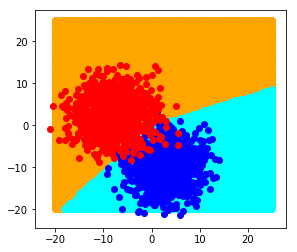

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.704
･ CPU:          0          0      4,357 MB |
･ GPU:          0          0      3,793 MB |


In [115]:
mp_r = mp[idx==0]
mp_b = mp[idx==1]
plt.figure(figsize=(4.5,4))
plt.scatter(mp_r[:,0].cpu(),mp_r[:,1].cpu(),color='orange')
plt.scatter(mp_b[:,0].cpu(),mp_b[:,1].cpu(),color='cyan')
plt.scatter(X[yn==1,0],X[yn==1,1],color='blue')
plt.scatter(X[yn==0,0],X[yn==0,1],color='red')

# Plots

In [161]:
torchdiag_tot = np.array([160.37, 3.0164, 16.1914, 17.0194])
torchdiag_tr = np.array([142.7278, 0.8056, 13.8606, 0.4075])
torchdiag_diff = torchdiag_tot - torchdiag_tr

torch_tot_sk = np.array([25.856, 19.8367])
torch_tr_sk = np.array([23.8455, 14.2507])
torch_diff_sk = torch_tot_sk - torch_tr_sk

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.006
･ CPU:          0          0      4,367 MB |
･ GPU:          0          0      2,105 MB |


Text(0.5, 1.0, 'Training (diagonal - SGD)')

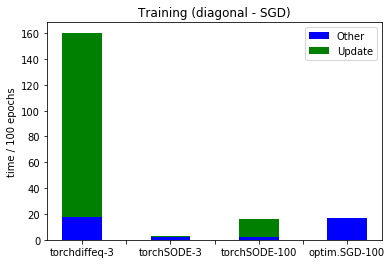

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.269
･ CPU:          0          0      4,375 MB |
･ GPU:          0          0      2,105 MB |


In [184]:
width = 0.45
y_pos = np.arange(4)
plt.bar(y_pos, torchdiag_diff, width, color='blue')
plt.bar(y_pos, torchdiag_tr, width, bottom=torchdiag_diff, color='green')
plt.legend(['Other', 'Update'])
ax = plt.gca()
ax.set_xticklabels(['', 'torchdiffeq-3', '', 'torchSODE-3', '', 'torchSODE-100', '', 'optim.SGD-100'])
plt.ylabel('time / 100 epochs')
plt.title('Training (diagonal - SGD)')

Text(0.5, 1.0, 'Training (skew block - SGD with momentum)')

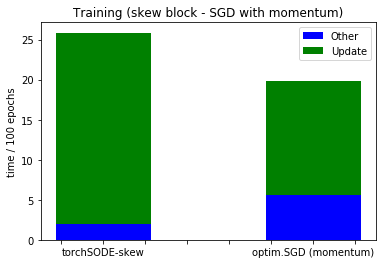

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.250
･ CPU:          0          0      4,377 MB |
･ GPU:          0          0      2,105 MB |


In [189]:
width = 0.45
y_pos = np.arange(2)
plt.bar(y_pos, torch_diff_sk, width, color='blue')
plt.bar(y_pos, torch_tr_sk, width, bottom=torch_diff_sk, color='green')
plt.legend(['Other', 'Update'])
ax = plt.gca()
ax.set_xticklabels(['', '', 'torchSODE-skew', '', '', '', '', 'optim.SGD (momentum)', ''])
plt.ylabel('time / 100 epochs')
plt.title('Training (skew block - SGD with momentum)')

In [193]:
memory = np.array([784, 24, 240])

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.001
･ CPU:          0          0      4,378 MB |
･ GPU:          0          0      2,105 MB |


[Text(0, 0, ''),
 Text(0, 0, 'torchdiffeq-3'),
 Text(0, 0, ''),
 Text(0, 0, 'torchSODE-3'),
 Text(0, 0, ''),
 Text(0, 0, 'torchSODE-100')]

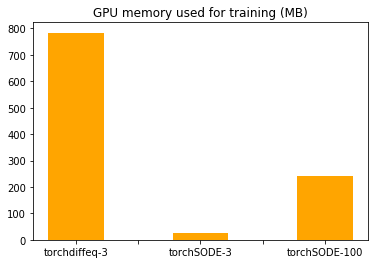

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.207
･ CPU:          0          0      4,379 MB |
･ GPU:          0          0      2,105 MB |


In [199]:
width = 0.45
y_pos = np.arange(3)
plt.bar(y_pos, memory, width, color='orange')
plt.title('GPU memory used for training (MB)')
ax = plt.gca()
ax.set_xticklabels(['', 'torchdiffeq-3', '', 'torchSODE-3', '', 'torchSODE-100'])